In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
df =pd.read_csv('tweet.csv')
df

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...
1810,1810,netral,Negarawan sejati sll bangga dan mengedepankan ...
1811,1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...


In [32]:
# menghilangkan kolom yang Unnamed:0 karena tidak dibutuhkan
df.drop('Unnamed: 0',axis=1, inplace=True)
df.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


## 1. Data Prepocessing

### 1.1. Data Prepocessing memperhatikan emoji dan hashtag

In [34]:
# cek dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


#### INSIGHT :
* data tidak ada yang kosong

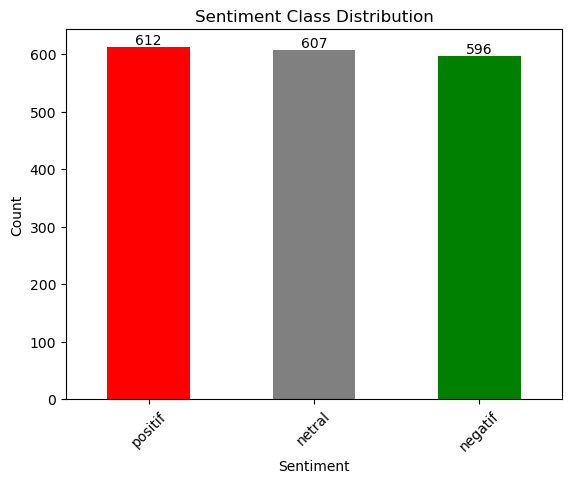

In [36]:
# Melihat sebaran label
import matplotlib.pyplot as plt

class_dist = df['sentimen'].value_counts()

ax = class_dist.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Add counts on top of the bars
for index, value in enumerate(class_dist):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

## INSIGHT
* Berdasarkan sebaran label tersebut maka disimpulkan bahwa dataset BALANCE

#### 1. MEMPERHATIKAN HASHTAG dan EMOJI

In [44]:
import demoji
demoji.download_codes()
def count_special_elements(text):
    # Count URLs
    urls = len(re.findall(r'http\S+|www\S+|https\S+', text))
    # Count mentions/hashtags
    mentions_hashtags = len(re.findall(r'[@#]\w+', text))
    # Count emojis
    emojis = len(demoji.findall(text))
    return pd.Series([urls, mentions_hashtags, emojis])

df[['urls', 'mentions_hashtags', 'emojis']] = df['tweet'].apply(count_special_elements)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12076\1365334961.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


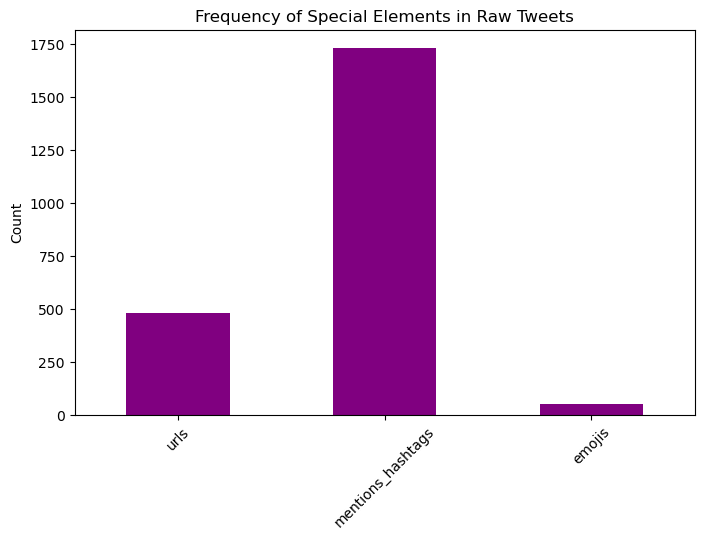

In [46]:
special_elements = df[['urls', 'mentions_hashtags', 'emojis']].sum()
plt.figure(figsize=(8, 5))
special_elements.plot(kind='bar', color='purple')
plt.title('Frequency of Special Elements in Raw Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### INSIGHT :
* jumlah hashtag banyak, sehingga bisa dipertimbangkan untuk analisa sentimen analysis
* Jumlah emoji sedikit, bisa dihilangkan saja

In [52]:
# AMBIL KATA HASHTAG dan MENGHAPUS EMOJI
import pandas as pd
import re
import emoji

# Fungsi untuk mengambil kata setelah hashtag dan memisahkan tiap kata dengan spasi
def extract_and_space_hashtags(text):
    hashtags = re.findall(r'#([A-Za-z0-9_]+)', text)  # Ambil kata setelah hashtag tanpa tanda #
    spaced_hashtags = [' '.join(re.findall(r'[A-Z][a-z]*|[a-z]+', tag)) for tag in hashtags]  # Pisahkan tiap kata
    return ' '.join(spaced_hashtags)

# Fungsi untuk menghapus emoji dari teks
def remove_emojis(text):
    text = emoji.replace_emoji(text, replace='')
    return re.sub(r'#([A-Za-z0-9_]+)', '', text).strip()  # Hapus hashtag dari teks asli

# Terapkan ke dataset
df['only_hashtags'] = df['tweet'].apply(extract_and_space_hashtags)  # Ambil kata setelah hashtag tanpa tanda #
df['clean_tweet'] = df['tweet'].apply(remove_emojis)  # Hapus emoji dan hashtag dari teks

# Gabungkan isi tweet dengan kata dari hashtag
df['combined_tweet'] = df['clean_tweet'] + ' ' + df['only_hashtags']

df

,sentimen,tweet,urls,mentions_hashtags,emojis,only_hashtags,clean_tweet,combined_tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,1,2,0,,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",1,0,0,,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",0,3,0,Indonesia Maju Jokowi Lagi Jokowi Menang Total...,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",0,0,0,,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,0,0,0,,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,0,1,0,Ganti Presiden,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,0,1,0,Putihkan G B K,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,1,0,0,,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,1,0,0,,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...


In [54]:
# Data tersebut untuk analisa lebih lanjut yang utama adalah 2 feature yaitu clean text dan combine text yang ditambahkan hashtag
# ambil kolom utama untuk bahan analisa lebih lanjut
df=df[['sentimen','tweet','clean_tweet','combined_tweet']]
df

,sentimen,tweet,clean_tweet,combined_tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...


In [56]:
# merubah nama kolom combine_tweet biar lebih informatif
df.rename(columns={'combined_tweet': 'clean_tweetag'}, inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12076\2798445888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'combined_tweet': 'clean_tweetag'}, inplace=True)


In [58]:
df

,sentimen,tweet,clean_tweet,clean_tweetag
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...


In [60]:
# supaya tidak perlu merubah2 lagi, dataset disimpan ke file exel
df.to_excel("tweet_clean_hashtag.xlsx", index=False)  # index=False agar tidak menyimpan indeks

In [9]:
df=pd.read_excel('tweet_clean_hashtag.xlsx')
df

,sentimen,tweet,clean_tweet,clean_tweetag
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...


#### 2. PREPOCESSING LANJUTAN

#### 2.1. TANPA HASHTAG / Kolom clean tweet

In [13]:
df_ct=df.copy()

In [15]:
df_ct.head()

,sentimen,tweet,clean_tweet,clean_tweetag
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...


In [17]:
# 2.1. TANPA HASHTAG pada kolom clean tweet
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText, Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pastikan Anda telah mengunduh resource NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing Function
def clean_text(text):
    text = text.lower()  # Konversi ke lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus URL
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Hapus karakter spesial
    text = text.translate(str.maketrans("", "", string.punctuation))  # Hapus tanda baca
    return text

# Stopwords & Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def preprocess(text, use_stemming=False):
    text = clean_text(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]  # Stopword removal
    if use_stemming:
        words = [stemmer.stem(word) for word in words]  # Stemming
    return " ".join(words)

# Terapkan Preprocessing dengan dan tanpa stemming
df_ct['clean_tweet_nostem'] = df_ct['clean_tweet'].apply(lambda x: preprocess(x, use_stemming=False))
df_ct['clean_tweet_stem'] = df_ct['clean_tweet'].apply(lambda x: preprocess(x, use_stemming=True))

# Label Encoding
df_ct['label'] = df['sentimen'].map({'positif': 1, 'netral': 0, 'negatif': -1})


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df_ct

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweet_nostem,clean_tweet_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1 hrs ceramah damai indonesiaku 2 perekonomian...,1 hrs ceramah damai indonesia 2 ekonomi baik,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [ ]:
# supaya tidak perlu merubah2 lagi, dataset disimpan ke file exel
df_ct.to_excel("tweet_clean_nostemnstem.xlsx", index=False)  # index=False agar tidak menyimpan indeks

In [21]:
df_ct['clean_tweet_nostem'] = df_ct['clean_tweet_nostem'].str.replace(r'\d+', '', regex=True)
df_ct

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweet_nostem,clean_tweet_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,hrs ceramah damai indonesiaku perekonomian m...,1 hrs ceramah damai indonesia 2 ekonomi baik,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [23]:
df_ct['clean_tweet_stem'] = df_ct['clean_tweet_stem'].str.replace(r'\d+', '', regex=True)
df_ct

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweet_nostem,clean_tweet_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,hrs ceramah damai indonesiaku perekonomian m...,hrs ceramah damai indonesia ekonomi baik,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [25]:
# supaya tidak perlu merubah2 lagi, dataset disimpan ke file exel
df_ct.to_excel("tweet_cleantweet_stemnostem.xlsx", index=False)  # index=False agar tidak menyimpan indeks

#### 2.1. DENGAN HASHTAG / Kolom clean_tweetag

In [33]:
df_tweetag=df.copy()

In [35]:
df_tweetag

,sentimen,tweet,clean_tweet,clean_tweetag
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...
...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...


In [37]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText, Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pastikan Anda telah mengunduh resource NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing Function
def clean_text(text):
    text = text.lower()  # Konversi ke lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus URL
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Hapus karakter spesial
    text = text.translate(str.maketrans("", "", string.punctuation))  # Hapus tanda baca
    return text

# Stopwords & Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def preprocess(text, use_stemming=False):
    text = clean_text(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]  # Stopword removal
    if use_stemming:
        words = [stemmer.stem(word) for word in words]  # Stemming
    return " ".join(words)

# Terapkan Preprocessing dengan dan tanpa stemming
df_tweetag['clean_tweetag_nostem'] = df_tweetag['clean_tweetag'].apply(lambda x: preprocess(x, use_stemming=False))
df_tweetag['clean_tweetag_stem'] = df_tweetag['clean_tweetag'].apply(lambda x: preprocess(x, use_stemming=True))

# Label Encoding
df_tweetag['label'] = df_tweetag['sentimen'].map({'positif': 1, 'netral': 0, 'negatif': -1})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
df_tweetag

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweetag_nostem,clean_tweetag_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1 hrs ceramah damai indonesiaku 2 perekonomian...,1 hrs ceramah damai indonesia 2 ekonomi baik p...,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [43]:
df_tweetag['clean_tweetag_nostem'] = df_tweetag['clean_tweetag_nostem'].str.replace(r'\d+', '', regex=True)
df_tweetag['clean_tweetag_stem'] = df_tweetag['clean_tweetag_stem'].str.replace(r'\d+', '', regex=True)

In [45]:
# supaya tidak perlu merubah2 lagi, dataset disimpan ke file exel
df_tweetag.to_excel("tweet_cleantweetag_stemnostem.xlsx", index=False)  # index=False agar tidak menyimpan indeks

### 3. VEKTORISASI

#### A. PERSIAPAN VEKTORISASI DENGAN HASHTAG

In [85]:
df_withtag = pd.read_excel('tweet_cleantweetag_stemnostem.xlsx')
df_withtag

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweetag_nostem,clean_tweetag_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,hrs ceramah damai indonesiaku perekonomian m...,hrs ceramah damai indonesia ekonomi baik put...,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [89]:
# memisahkan train dan test : DENGAN HASTAG dan NO STEMMING

X_train_tag_nostem, X_test_tag_nostem, y_train_tag_nostem, y_test_tag_nostem = train_test_split(df_withtag['clean_tweetag_nostem'], df_withtag['label'], test_size=0.2, random_state=42)

In [91]:
# memisahkan train dan test : DENGAN HASTAG dan DENGAN STEMMING

X_train_tag_stem, X_test_tag_stem, y_train_tag_stem, y_test_tag_stem = train_test_split(df_withtag['clean_tweetag_stem'], df_withtag['label'], test_size=0.2, random_state=42)

In [93]:
df_notag = pd.read_excel('tweet_cleantweet_stemnostem.xlsx')
df_notag

,sentimen,tweet,clean_tweet,clean_tweetag,clean_tweet_nostem,clean_tweet_stem,label
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia dihargai bangsa asing berita...,prabowo indonesia harga bangsa asing berita ho...,-1
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batu langka tasbih jokowi hadiah habib luthfi ...,0
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....","Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...,era jokowi ekonomi indonesia pic twitter com w...,0
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...","Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...,sumatera selatan asi games dampak pd ekonomi l...,1
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...,negara ngutang bngun infrastruktur udah dipake...,-1
...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,negarawan sejati sll bangga depan harga bangsa...,0
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,hrs ceramah damai indonesiaku perekonomian m...,hrs ceramah damai indonesia ekonomi baik,0
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn dukung ekonomi negara j...,0
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa jokowi yuk,bantu maju ekonomi bangsa jokowi yuk,0


In [97]:
# Memisahkan train dan test : NO HASTGAS dan No stemming

X_train_notag_nostem, X_test_notag_nostem, y_train_notag_nostem, y_test_notag_nostem = train_test_split(df_notag['clean_tweet_nostem'], df_notag['label'], test_size=0.2, random_state=42)

In [99]:
# Memisahkan train dan test : NO HASTGAS dan dengan stemming

X_train_notag_stem, X_test_notag_stem, y_train_notag_stem, y_test_notag_stem = train_test_split(df_notag['clean_tweet_stem'], df_notag['label'], test_size=0.2, random_state=42)

### 3.1 Vektorisasi BOW

#### 3.1.1.A Vektorisasi BOW WITH HASHTAG stemming

In [124]:
X_train_tag_stem.head()

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
Name: clean_tweetag_stem, dtype: object

In [126]:
X_test_tag_stem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
Name: clean_tweetag_stem, dtype: object

In [132]:
vectorizer = CountVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_bow_tag_stem = vectorizer.fit_transform(X_train_tag_stem)
X_test_bow_tag_stem = vectorizer.transform(X_test_tag_stem)

# Konversi ke DataFrame
X_train_bow_tag_stem_df = pd.DataFrame(X_train_bow_tag_stem.toarray(), columns=vectorizer.get_feature_names_out())
X_train_bow_tag_stem_df = pd.DataFrame(X_train_bow_tag_stem.toarray(), columns=vectorizer.get_feature_names_out())


#### 3.1.1.B Vektorisasi BOW WITH HASHTAG No Stemming

In [120]:
X_train_tag_nostem.head()

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
Name: clean_tweetag_nostem, dtype: object

In [122]:
X_test_tag_nostem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
Name: clean_tweetag_nostem, dtype: object

In [136]:
vectorizer = CountVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_bow_tag_nostem = vectorizer.fit_transform(X_train_tag_nostem)
X_test_bow_tag_nostem = vectorizer.transform(X_test_tag_nostem)

# Konversi ke DataFrame
X_train_bow_tag_nostem_df = pd.DataFrame(X_train_bow_tag_nostem.toarray(), columns=vectorizer.get_feature_names_out())
X_train_bow_tag_nostem_df = pd.DataFrame(X_test_bow_tag_nostem.toarray(), columns=vectorizer.get_feature_names_out())


#### 3.1.2.A Vektorisasi BOW NO HASHTAG Stemming

In [142]:
X_train_notag_stem

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
                              ...                        
1130    salah perintah yg hukum ga ketat gw udh contoh...
1294    yg prabowo tanggung ulang prabowo salah jokowi...
860     nama jaman modern gaji ya transfer ambil pilih...
1459    alhamdulillah smoga laksana cita aamiin janji ...
1126    jebak kapabilitas jokowi kepala lepas kaki ika...
Name: clean_tweet_stem, Length: 1452, dtype: object

In [144]:
X_test_notag_stem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
                              ...                        
1125    fyi digital ekonomi papar cawapres  laku era p...
1142    prabowo debat sebut ekonomi deindustrialisasi ...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik bijak pic...
Name: clean_tweet_stem, Length: 363, dtype: object

In [148]:
vectorizer = CountVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_bow_notag_stem = vectorizer.fit_transform(X_train_notag_stem)
X_test_bow_notag_stem = vectorizer.transform(X_test_notag_stem)

# Konversi ke DataFrame
X_train_bow_notag_stem_df = pd.DataFrame(X_train_bow_notag_stem.toarray(), columns=vectorizer.get_feature_names_out())
X_train_bow_notag_stem_df = pd.DataFrame(X_train_bow_notag_stem.toarray(), columns=vectorizer.get_feature_names_out())

#### 3.1.2.B Vektorisasi BOW NO HASHTAG NO Stemming

In [138]:
X_train_notag_nostem

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
                              ...                        
1130    salah pemerintah yg hukumnya ga ketat gw udh c...
1294    yg prabowo bertanggung berulang prabowo menyal...
860     namanya jaman modern gaji ya ditransfer diambi...
1459    alhamdulillah smoga terlaksana cita aamiin jan...
1126    menjebak kapabilitas jokowi kepala dilepas kak...
Name: clean_tweet_nostem, Length: 1452, dtype: object

In [140]:
X_test_notag_nostem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
                              ...                        
1125    fyi digital ekonomi paparkan cawapres  lakukan...
1142    prabowo debat menyebut ekonomi deindustrialisa...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik kebijakan...
Name: clean_tweet_nostem, Length: 363, dtype: object

In [146]:
vectorizer = CountVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_bow_notag_nostem = vectorizer.fit_transform(X_train_notag_nostem)
X_test_bow_notag_nostem = vectorizer.transform(X_test_notag_nostem)

# Konversi ke DataFrame
X_train_bow_notag_nostem_df = pd.DataFrame(X_train_bow_notag_nostem.toarray(), columns=vectorizer.get_feature_names_out())
X_train_bow_notag_nostem_df = pd.DataFrame(X_test_bow_notag_nostem.toarray(), columns=vectorizer.get_feature_names_out())

### 3.2 Vektorisasi TFIDF

#### 3.2.1.A Vektorisasi TFIDF WITH HASHTAG dengan stemming

In [161]:
X_train_tag_stem.head()

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
Name: clean_tweetag_stem, dtype: object

In [163]:
X_test_tag_stem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
Name: clean_tweetag_stem, dtype: object

In [165]:
tfidf_vectorizer = TfidfVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_tfidf_tag_stem = tfidf_vectorizer.fit_transform(X_train_tag_stem)
X_test_tfidf_tag_stem = tfidf_vectorizer.transform(X_test_tag_stem)

# Konversi ke DataFrame
X_train_tfidf_tag_stem_df = pd.DataFrame(X_train_tfidf_tag_stem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_tag_stem_df = pd.DataFrame(X_test_tfidf_tag_stem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


#### 3.2.1.B Vektorisasi TFIDF WITH HASHTAG NO stemming

In [167]:
X_train_tag_nostem.head()

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
Name: clean_tweetag_nostem, dtype: object

In [169]:
X_test_tag_nostem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
Name: clean_tweetag_nostem, dtype: object

In [171]:
tfidf_vectorizer = TfidfVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_tfidf_tag_nostem = tfidf_vectorizer.fit_transform(X_train_tag_nostem)
X_test_tfidf_tag_nostem = tfidf_vectorizer.transform(X_test_tag_nostem)

# Konversi ke DataFrame
X_train_tfidf_tag_nostem_df = pd.DataFrame(X_train_tfidf_tag_nostem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_tag_nostem_df = pd.DataFrame(X_test_tfidf_tag_nostem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


#### 3.2.2.A Vektorisasi TFIDF NO HASHTAG dengan stemming

In [173]:
X_train_notag_stem

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
                              ...                        
1130    salah perintah yg hukum ga ketat gw udh contoh...
1294    yg prabowo tanggung ulang prabowo salah jokowi...
860     nama jaman modern gaji ya transfer ambil pilih...
1459    alhamdulillah smoga laksana cita aamiin janji ...
1126    jebak kapabilitas jokowi kepala lepas kaki ika...
Name: clean_tweet_stem, Length: 1452, dtype: object

In [175]:
X_test_notag_stem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
                              ...                        
1125    fyi digital ekonomi papar cawapres  laku era p...
1142    prabowo debat sebut ekonomi deindustrialisasi ...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik bijak pic...
Name: clean_tweet_stem, Length: 363, dtype: object

In [177]:
tfidf_vectorizer = TfidfVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_tfidf_notag_stem = tfidf_vectorizer.fit_transform(X_train_notag_stem)
X_test_tfidf_notag_stem = tfidf_vectorizer.transform(X_test_notag_stem)

# Konversi ke DataFrame
X_train_tfidf_notag_stem_df = pd.DataFrame(X_train_tfidf_notag_stem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_notag_stem_df = pd.DataFrame(X_test_tfidf_notag_stem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#### 3.2.2.B Vektorisasi TFIDF NO HASHTAG NO stemming

In [179]:
X_train_notag_nostem

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
                              ...                        
1130    salah pemerintah yg hukumnya ga ketat gw udh c...
1294    yg prabowo bertanggung berulang prabowo menyal...
860     namanya jaman modern gaji ya ditransfer diambi...
1459    alhamdulillah smoga terlaksana cita aamiin jan...
1126    menjebak kapabilitas jokowi kepala dilepas kak...
Name: clean_tweet_nostem, Length: 1452, dtype: object

In [181]:
X_test_notag_nostem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
                              ...                        
1125    fyi digital ekonomi paparkan cawapres  lakukan...
1142    prabowo debat menyebut ekonomi deindustrialisa...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik kebijakan...
Name: clean_tweet_nostem, Length: 363, dtype: object

In [183]:
tfidf_vectorizer = TfidfVectorizer()

# Fit di X_train, transform X_train & X_test
X_train_tfidf_notag_nostem = tfidf_vectorizer.fit_transform(X_train_notag_nostem)
X_test_tfidf_notag_nostem = tfidf_vectorizer.transform(X_test_notag_nostem)

# Konversi ke DataFrame
X_train_tfidf_notag_nostem_df = pd.DataFrame(X_train_tfidf_notag_nostem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_notag_nostem_df = pd.DataFrame(X_test_tfidf_notag_nostem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### 3.3. Vektorisasi word2vec

#### 3.3.1.A Vektorisasi word2vec WITH HASHTAG with stemming

In [188]:
X_train_tag_stem.head()

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
Name: clean_tweetag_stem, dtype: object

In [190]:
X_test_tag_stem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
Name: clean_tweetag_stem, dtype: object

In [192]:
# Tokenisasi data
X_train_tokenized = [tweet.split() for tweet in X_train_tag_stem]
X_test_tokenized = [tweet.split() for tweet in X_test_tag_stem]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan rata-rata embedding
def text_to_embedding(text, model, dim=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(dim)

# Transform data ke embedding
X_train_w2v_tag_stem = np.array([text_to_embedding(text, w2v_model) for text in X_train_tag_stem])
X_test_w2v_tag_stem = np.array([text_to_embedding(text, w2v_model) for text in X_test_tag_stem])

# Konversi ke DataFrame
X_train_w2v_tag_stem_df = pd.DataFrame(X_train_w2v_tag_stem)
X_test_w2v_tag_stem__df = pd.DataFrame(X_test_w2v_tag_stem)

#### 3.3.1.B. Vektorisasi word2vec WITH HASHTAG NO stemming

In [194]:
X_train_tag_nostem.head()

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
Name: clean_tweetag_nostem, dtype: object

In [196]:
X_test_tag_nostem.head()

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
Name: clean_tweetag_nostem, dtype: object

In [198]:
# Tokenisasi data
X_train_tokenized = [tweet.split() for tweet in X_train_tag_nostem]
X_test_tokenized = [tweet.split() for tweet in X_test_tag_nostem]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan rata-rata embedding
def text_to_embedding(text, model, dim=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(dim)

# Transform data ke embedding
X_train_w2v_tag_nostem = np.array([text_to_embedding(text, w2v_model) for text in X_train_tag_nostem])
X_test_w2v_tag_nostem = np.array([text_to_embedding(text, w2v_model) for text in X_test_tag_nostem])

# Konversi ke DataFrame
X_train_w2v_tag_nostem_df = pd.DataFrame(X_train_w2v_tag_nostem)
X_test_w2v_tag_nostem__df = pd.DataFrame(X_test_w2v_tag_nostem)

#### 3.3.2.A Vektorisasi word2vec NO HASHTAG WITH stemming

In [202]:
X_train_notag_stem

609     komentar bagus alangkah indshnya bilang jokowi...
844     jokowi tumbuh ekonomi  syukur kufur nikmat pic...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah tutup keren dr prabowo sandiuno ...
614     utara jokowi kemaren esports kontribusi ekonom...
                              ...                        
1130    salah perintah yg hukum ga ketat gw udh contoh...
1294    yg prabowo tanggung ulang prabowo salah jokowi...
860     nama jaman modern gaji ya transfer ambil pilih...
1459    alhamdulillah smoga laksana cita aamiin janji ...
1126    jebak kapabilitas jokowi kepala lepas kaki ika...
Name: clean_tweet_stem, Length: 1452, dtype: object

In [204]:
X_test_notag_stem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk terima gaji prabowo sandi lim...
1750    bang sandiuno prabowo tempat tugas karna bangg...
674     ekonomi aja hidup buruh tunggu realisasi janji...
111     gak ngaruh jokowi kutub utara rakyat tau baran...
                              ...                        
1125    fyi digital ekonomi papar cawapres  laku era p...
1142    prabowo debat sebut ekonomi deindustrialisasi ...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik bijak pic...
Name: clean_tweet_stem, Length: 363, dtype: object

In [206]:
# Tokenisasi data
X_train_tokenized = [tweet.split() for tweet in X_train_notag_stem]
X_test_tokenized = [tweet.split() for tweet in X_test_notag_stem]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan rata-rata embedding
def text_to_embedding(text, model, dim=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(dim)

# Transform data ke embedding
X_train_w2v_notag_stem = np.array([text_to_embedding(text, w2v_model) for text in X_train_notag_stem])
X_test_w2v_notag_stem = np.array([text_to_embedding(text, w2v_model) for text in X_test_notag_stem])

# Konversi ke DataFrame
X_train_w2v_notag_stem_df = pd.DataFrame(X_train_w2v_notag_stem)
X_test_w2v_notag_stem__df = pd.DataFrame(X_test_w2v_notag_stem)

#### 3.3.2.B Vektorisasi word2vec NO HASHTAG NO stemming

In [208]:
X_train_notag_nostem

609     komentarnya bagus alangkah indshnya bilang jok...
844     jokowi pertumbuhan ekonomi  disyukuri kufur ni...
300     ciwi ciwi harga skincare turun tusuk prabowo s...
1702    alhamdulillah penutup terkeren dr prabowo sand...
614     diutarakan jokowi kemaren esports berkontribus...
                              ...                        
1130    salah pemerintah yg hukumnya ga ketat gw udh c...
1294    yg prabowo bertanggung berulang prabowo menyal...
860     namanya jaman modern gaji ya ditransfer diambi...
1459    alhamdulillah smoga terlaksana cita aamiin jan...
1126    menjebak kapabilitas jokowi kepala dilepas kak...
Name: clean_tweet_nostem, Length: 1452, dtype: object

In [210]:
X_test_notag_nostem

567     milenial ga paham potensi bisnis dunia digital...
432     presiden yg  tdk menerima gaji prabowo sandi d...
1750    bang sandiuno prabowo menempatkan tugasnya kar...
674     ekonomi aja kehidupan buruh menunggu realisasi...
111     gak ngaruh jokowi kutub utara rakyat taunya ba...
                              ...                        
1125    fyi digital ekonomi paparkan cawapres  lakukan...
1142    prabowo debat menyebut ekonomi deindustrialisa...
1512    gaji prabowo sandi kaum yatim dhuafa suda mant...
170     jokowi mohmahfudmd sbyudhoyono setkabgoid sala...
292     analis politik ekonomi jokowi kritik kebijakan...
Name: clean_tweet_nostem, Length: 363, dtype: object

In [212]:
# Tokenisasi data
X_train_tokenized = [tweet.split() for tweet in X_train_notag_nostem]
X_test_tokenized = [tweet.split() for tweet in X_test_notag_nostem]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan rata-rata embedding
def text_to_embedding(text, model, dim=100):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(dim)

# Transform data ke embedding
X_train_w2v_notag_nostem = np.array([text_to_embedding(text, w2v_model) for text in X_train_notag_nostem])
X_test_w2v_notag_nostem = np.array([text_to_embedding(text, w2v_model) for text in X_test_notag_nostem])

# Konversi ke DataFrame
X_train_w2v_notag_nostem_df = pd.DataFrame(X_train_w2v_notag_nostem)
X_test_w2v_notag_nostem__df = pd.DataFrame(X_test_w2v_notag_nostem)

### 3.4. Vektorisasi Fastext

#### 3.4.1. Vektorisasi Fastext dengan stemming

#### 3.4.2. Vektorisasi Fastext tidak dengan stemming

### 4. PENGEMBANGAN MODEL

#### 4.1. MODEL RANDOM FOREST 

#### 4.1.1. Vektorisasi BOW

#### 4.1.1.A. BOW WITH HASHTAG AND STEMMING

In [233]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_bow_tag_stem, y_train_tag_stem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [235]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [237]:
# selanjutnya membuat model rf 
best_rf_bow_tag_stem = RandomForestClassifier(random_state=42,criterion='gini', max_depth=20,min_samples_leaf=4,min_samples_split=10,n_estimators=100 )

In [239]:
best_rf_bow_tag_stem.fit(X_train_bow_tag_stem,y_train_tag_stem)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.6116
✅ Precision: 0.6207
✅ Recall: 0.6116
✅ F1 Score: 0.6082

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.60      0.69      0.64       115
      Netral       0.58      0.68      0.62       118
     Positif       0.68      0.48      0.57       130

    accuracy                           0.61       363
   macro avg       0.62      0.62      0.61       363
weighted avg       0.62      0.61      0.61       363



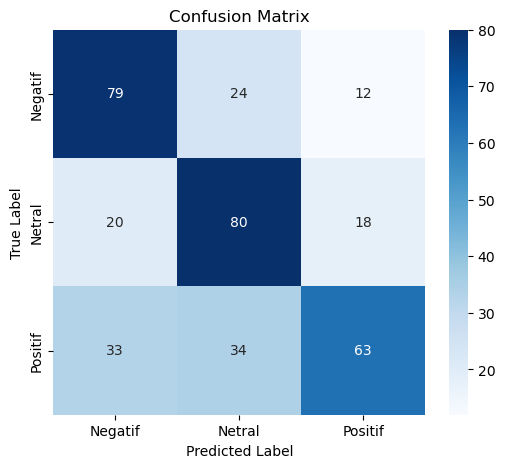

In [243]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_bow_tag_stem.predict(X_test_bow_tag_stem)

# Evaluasi Model
accuracy = accuracy_score(y_test_tag_stem, y_pred_rf)
precision = precision_score(y_test_tag_stem, y_pred_rf, average='weighted')
recall = recall_score(y_test_tag_stem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_tag_stem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_tag_stem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_tag_stem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#### 4.1.1.B. BOW WITH HASHTAG AND NO STEMMING

In [245]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_bow_tag_nostem, y_train_tag_nostem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [247]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [249]:
# selanjutnya membuat model rf 
best_rf_bow_tag_nostem = RandomForestClassifier(random_state=42,criterion='gini', max_depth=30,min_samples_leaf=2,min_samples_split=10,n_estimators=100 )

In [251]:
best_rf_bow_tag_nostem.fit(X_train_bow_tag_nostem,y_train_tag_nostem)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.6006
✅ Precision: 0.6152
✅ Recall: 0.6006
✅ F1 Score: 0.5951

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.59      0.72      0.65       115
      Netral       0.55      0.65      0.60       118
     Positif       0.69      0.45      0.54       130

    accuracy                           0.60       363
   macro avg       0.61      0.61      0.60       363
weighted avg       0.62      0.60      0.60       363



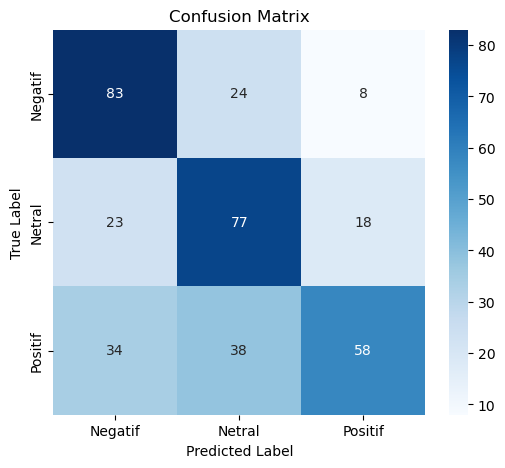

In [255]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_bow_tag_nostem.predict(X_test_bow_tag_nostem)

# Evaluasi Model
accuracy = accuracy_score(y_test_tag_nostem, y_pred_rf)
precision = precision_score(y_test_tag_nostem, y_pred_rf, average='weighted')
recall = recall_score(y_test_tag_nostem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_tag_nostem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_tag_nostem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_tag_nostem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 4.1.1.C. BOW  NO HASHTAG, STEMMING

In [262]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_bow_notag_stem, y_train_notag_stem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [264]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [266]:
# selanjutnya membuat model rf 
best_rf_bow_notag_stem = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=20,min_samples_leaf=4,min_samples_split=2,n_estimators=100 )

In [268]:
best_rf_bow_notag_stem.fit(X_train_bow_notag_stem,y_train_notag_stem)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                       random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.6198
✅ Precision: 0.6255
✅ Recall: 0.6198
✅ F1 Score: 0.6176

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.62      0.70      0.65       115
      Netral       0.59      0.66      0.62       118
     Positif       0.67      0.52      0.58       130

    accuracy                           0.62       363
   macro avg       0.62      0.62      0.62       363
weighted avg       0.63      0.62      0.62       363



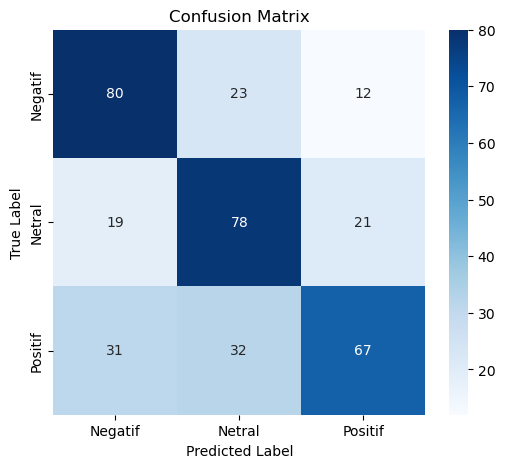

In [270]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_bow_notag_stem.predict(X_test_bow_notag_stem)

# Evaluasi Model
accuracy = accuracy_score(y_test_notag_stem, y_pred_rf)
precision = precision_score(y_test_notag_stem, y_pred_rf, average='weighted')
recall = recall_score(y_test_notag_stem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_notag_stem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_notag_stem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_notag_stem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 4.1.1.D. WITH NO HASHTAG,  NO STEMMING

In [272]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_bow_notag_nostem, y_train_notag_nostem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [274]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [276]:
# selanjutnya membuat model rf 
best_rf_bow_notag_nostem = RandomForestClassifier(random_state=42,criterion='gini', max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=300 )

In [278]:
best_rf_bow_notag_nostem.fit(X_train_bow_notag_nostem,y_train_notag_nostem)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.5758
✅ Precision: 0.5855
✅ Recall: 0.5758
✅ F1 Score: 0.5701

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.58      0.64      0.61       115
      Netral       0.54      0.68      0.60       118
     Positif       0.63      0.42      0.51       130

    accuracy                           0.58       363
   macro avg       0.58      0.58      0.57       363
weighted avg       0.59      0.58      0.57       363



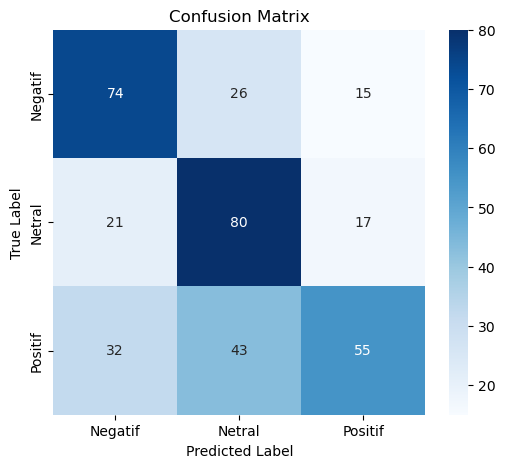

In [280]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_bow_notag_nostem.predict(X_test_bow_notag_nostem)

# Evaluasi Model
accuracy = accuracy_score(y_test_notag_nostem, y_pred_rf)
precision = precision_score(y_test_notag_nostem, y_pred_rf, average='weighted')
recall = recall_score(y_test_notag_nostem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_notag_nostem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_notag_nostem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_notag_nostem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 4.1.2. Vektorisasi TFIDF

### 4.1.2.A Random forest hashtag dan stemming

In [284]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf_tag_stem, y_train_tag_stem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [286]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [288]:
# selanjutnya membuat model rf 
best_rf_tfidf_tag_stem = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=30,min_samples_leaf=1,min_samples_split=5,n_estimators=300 )

In [290]:
best_rf_tfidf_tag_stem.fit(X_train_tfidf_tag_stem,y_train_tag_stem)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=5,
                       n_estimators=300, random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.5840
✅ Precision: 0.5924
✅ Recall: 0.5840
✅ F1 Score: 0.5809

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.58      0.69      0.63       115
      Netral       0.55      0.61      0.58       118
     Positif       0.65      0.47      0.54       130

    accuracy                           0.58       363
   macro avg       0.59      0.59      0.58       363
weighted avg       0.59      0.58      0.58       363



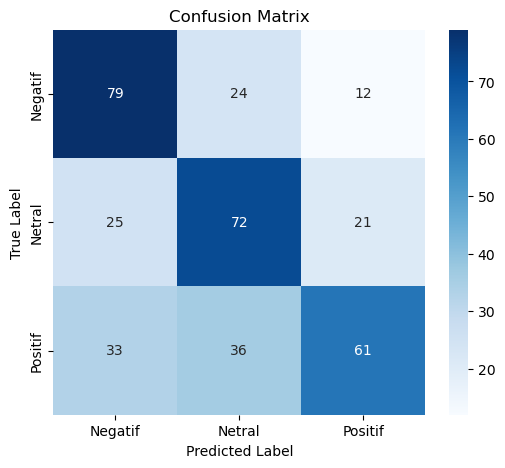

In [292]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_tfidf_tag_stem.predict(X_test_tfidf_tag_stem)

# Evaluasi Model
accuracy = accuracy_score(y_test_tag_stem, y_pred_rf)
precision = precision_score(y_test_tag_stem, y_pred_rf, average='weighted')
recall = recall_score(y_test_tag_stem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_tag_stem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_tag_stem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_tag_stem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 4.1.2.B Random forest hashtag dan no stemming

In [300]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf_tag_nostem, y_train_tag_nostem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [302]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [304]:
# selanjutnya membuat model rf 
best_rf_tfidf_tag_nostem = RandomForestClassifier(random_state=42,criterion='gini', max_depth=20,min_samples_leaf=2,min_samples_split=2,n_estimators=300 )

In [306]:
best_rf_tfidf_tag_nostem.fit(X_train_tfidf_tag_nostem,y_train_tag_nostem)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.5950
✅ Precision: 0.6142
✅ Recall: 0.5950
✅ F1 Score: 0.5903

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.56      0.71      0.63       115
      Netral       0.56      0.64      0.60       118
     Positif       0.71      0.45      0.55       130

    accuracy                           0.60       363
   macro avg       0.61      0.60      0.59       363
weighted avg       0.61      0.60      0.59       363



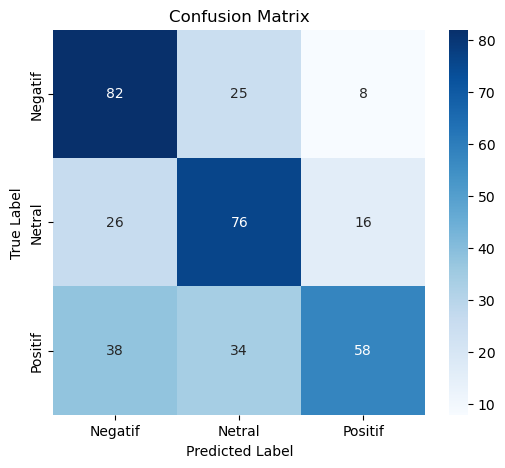

In [308]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_tfidf_tag_nostem.predict(X_test_tfidf_tag_nostem)

# Evaluasi Model
accuracy = accuracy_score(y_test_tag_nostem, y_pred_rf)
precision = precision_score(y_test_tag_nostem, y_pred_rf, average='weighted')
recall = recall_score(y_test_tag_nostem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_tag_nostem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_tag_nostem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_tag_nostem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 4.1.2.C Random forest TFIDF NO hashtag dan stemming

In [311]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf_notag_stem, y_train_notag_stem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [313]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [315]:
# selanjutnya membuat model rf 
best_rf_tfidf_notag_stem = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=30,min_samples_leaf=1,min_samples_split=10,n_estimators=200 )

In [317]:
best_rf_tfidf_notag_stem.fit(X_train_tfidf_notag_stem,y_train_notag_stem)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=200, random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.6061
✅ Precision: 0.6174
✅ Recall: 0.6061
✅ F1 Score: 0.6037

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.59      0.67      0.63       115
      Netral       0.57      0.67      0.61       118
     Positif       0.69      0.49      0.57       130

    accuracy                           0.61       363
   macro avg       0.61      0.61      0.60       363
weighted avg       0.62      0.61      0.60       363



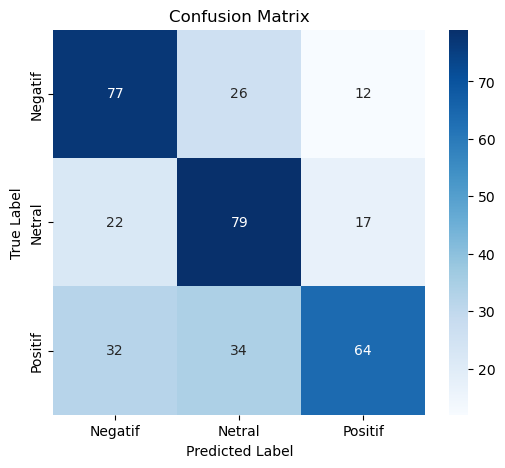

In [319]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_tfidf_notag_stem.predict(X_test_tfidf_notag_stem)

# Evaluasi Model
accuracy = accuracy_score(y_test_notag_stem, y_pred_rf)
precision = precision_score(y_test_notag_stem, y_pred_rf, average='weighted')
recall = recall_score(y_test_notag_stem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_notag_stem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_notag_stem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_notag_stem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 4.1.2.C Random forest TFIDF NO hashtag dan No stemming

In [323]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf_notag_nostem, y_train_notag_nostem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [325]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [327]:
# selanjutnya membuat model rf 
best_rf_tfidf_notag_nostem = RandomForestClassifier(random_state=42,criterion='gini', max_depth=30,min_samples_leaf=2,min_samples_split=10,n_estimators=300 )

In [329]:
best_rf_tfidf_notag_nostem.fit(X_train_tfidf_notag_nostem,y_train_notag_nostem)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=300, random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.6006
✅ Precision: 0.6114
✅ Recall: 0.6006
✅ F1 Score: 0.5961

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.60      0.64      0.62       115
      Netral       0.56      0.71      0.63       118
     Positif       0.67      0.46      0.55       130

    accuracy                           0.60       363
   macro avg       0.61      0.61      0.60       363
weighted avg       0.61      0.60      0.60       363



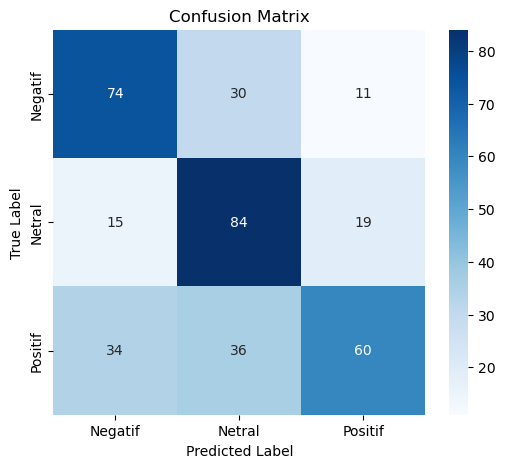

In [331]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_tfidf_notag_nostem.predict(X_test_tfidf_notag_nostem)

# Evaluasi Model
accuracy = accuracy_score(y_test_notag_nostem, y_pred_rf)
precision = precision_score(y_test_notag_nostem, y_pred_rf, average='weighted')
recall = recall_score(y_test_notag_nostem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_notag_nostem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_notag_nostem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_notag_nostem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 4.1.3. Vektorisasi Word2VEC

#### 4.1.3. Random forest word2vec with hashtag dan stemming

In [337]:
# Parameter Grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam Random Forest
    'max_depth': [10, 20, 30],  # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum sampel di tiap daun
    'criterion': ['gini', 'entropy']  # Cara mengukur impurity dalam node
}

rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_w2v_tag_stem, y_train_tag_stem)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [339]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [341]:
# selanjutnya membuat model rf 
best_rf_w2v_tag_stem = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=30,min_samples_leaf=4,min_samples_split=10,n_estimators=300 )

In [343]:
best_rf_w2v_tag_stem.fit(X_train_w2v_tag_stem,y_train_tag_stem)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=300, random_state=42)

📊 Random Forest Evaluation Metrics:
✅ Accuracy: 0.4793
✅ Precision: 0.4790
✅ Recall: 0.4793
✅ F1 Score: 0.4765

📑 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.54      0.57      0.55       115
      Netral       0.44      0.52      0.48       118
     Positif       0.46      0.37      0.41       130

    accuracy                           0.48       363
   macro avg       0.48      0.48      0.48       363
weighted avg       0.48      0.48      0.48       363



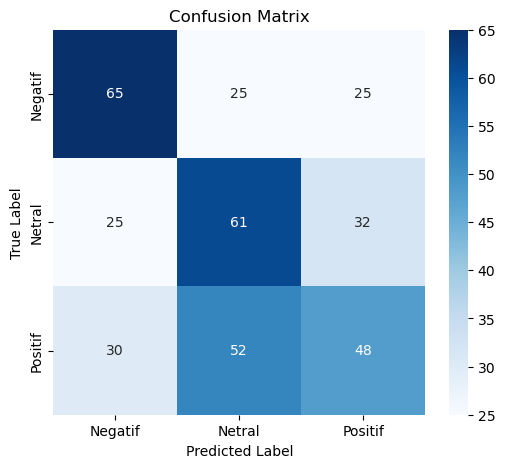

In [345]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan model terbaik dari GridSearchCV
#best_rf = grid_search.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf_w2v_tag_stem.predict(X_test_w2v_tag_stem)

# Evaluasi Model
accuracy = accuracy_score(y_test_tag_stem, y_pred_rf)
precision = precision_score(y_test_tag_stem, y_pred_rf, average='weighted')
recall = recall_score(y_test_tag_stem, y_pred_rf, average='weighted')
f1 = f1_score(y_test_tag_stem, y_pred_rf, average='weighted')

print("📊 Random Forest Evaluation Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Print Classification Report
print("\n📑 Classification Report:")
print(classification_report(y_test_tag_stem, y_pred_rf, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_tag_stem, y_pred_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### =========== KARENA HASIL AKURASI dllnya KECIL..., KONDISI LAIN PENDING ========

### 4.2. ALGORITMA LSTM

In [389]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

In [395]:
X_train = X_train_tag_stem.copy()
X_test = X_test_tag_stem.copy()
y_train = y_train_tag_stem.copy()
y_train = np.array(y_train)+1
y_test = y_test_tag_stem.copy()
y_test= np.array(y_test)+1


Evaluating LSTM with BOW
Epoch 1/5


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 - 253s - 6s/step - accuracy: 0.3347 - loss: 1.1010 - val_accuracy: 0.3251 - val_loss: 1.1024
Epoch 2/5
46/46 - 252s - 5s/step - accuracy: 0.3223 - loss: 1.1005 - val_accuracy: 0.3251 - val_loss: 1.1005
Epoch 3/5
46/46 - 279s - 6s/step - accuracy: 0.3182 - loss: 1.1013 - val_accuracy: 0.3581 - val_loss: 1.0976
Epoch 4/5
46/46 - 324s - 7s/step - accuracy: 0.3423 - loss: 1.1004 - val_accuracy: 0.3581 - val_loss: 1.0981
Epoch 5/5
46/46 - 256s - 6s/step - accuracy: 0.3202 - loss: 1.1015 - val_accuracy: 0.3581 - val_loss: 1.0979
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Accuracy: 0.3581267217630854
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00       118
           2       0.36      1.00      0.53       130

    accuracy                           0.36       363
   macro avg       0.12      0.33      0.18       363
weighted avg       0.13      0.36      0.19       363



C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

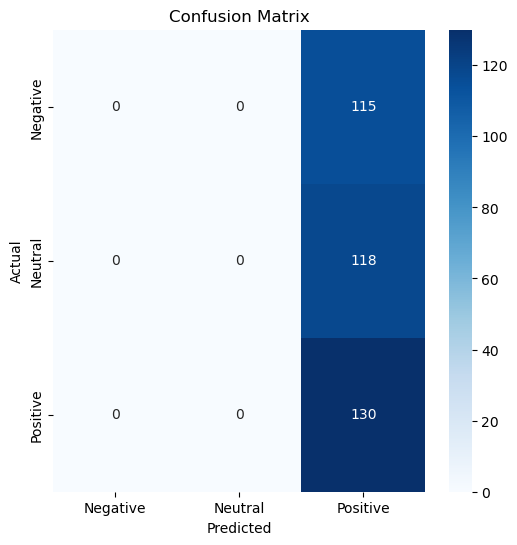


Evaluating LSTM with TF-IDF
Epoch 1/5


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 - 253s - 5s/step - accuracy: 0.3147 - loss: 1.1042 - val_accuracy: 0.3581 - val_loss: 1.0980
Epoch 2/5
46/46 - 263s - 6s/step - accuracy: 0.3182 - loss: 1.1011 - val_accuracy: 0.3168 - val_loss: 1.0985
Epoch 3/5
46/46 - 272s - 6s/step - accuracy: 0.3430 - loss: 1.0994 - val_accuracy: 0.3168 - val_loss: 1.1040
Epoch 4/5
46/46 - 263s - 6s/step - accuracy: 0.3106 - loss: 1.1024 - val_accuracy: 0.3168 - val_loss: 1.0990
Epoch 5/5
46/46 - 264s - 6s/step - accuracy: 0.3244 - loss: 1.1007 - val_accuracy: 0.3251 - val_loss: 1.0984
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Accuracy: 0.325068870523416
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.33      1.00      0.49       118
           2       0.00      0.00      0.00       130

    accuracy                           0.33       363
   macro avg       0.11      0.33      0.16       363
weighted avg       0.11      0.33      0.16       363



C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

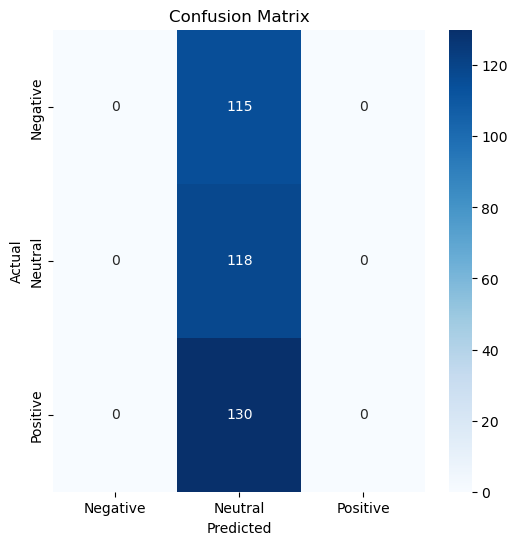


Evaluating LSTM with Word2Vec


ValueError: Layer embedding_3 weight shape (59, 100) is not compatible with provided weight shape (4717, 100).

In [397]:
# Tokenizer settings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Vektorisasi BOW dan TF-IDF
vectorizer_bow = CountVectorizer()
vectorizer_tfidf = TfidfVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train).toarray()
X_test_bow = vectorizer_bow.transform(X_test).toarray()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer_tfidf.transform(X_test).toarray()

# Word2Vec Model
word2vec = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

# LSTM Model

def build_lstm_model(input_dim, embedding_matrix=None):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(input_dim, 100, weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim, 100, input_length=max_length))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 sentiment classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training and Evaluation
def train_evaluate_lstm(X_train, X_test, y_train, y_test, embedding_matrix=None):
    model = build_lstm_model(X_train.shape[1], embedding_matrix)
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Run LSTM with different vectorization methods
print("\nEvaluating LSTM with BOW")
train_evaluate_lstm(X_train_bow, X_test_bow, y_train, y_test)

print("\nEvaluating LSTM with TF-IDF")
train_evaluate_lstm(X_train_tfidf, X_test_tfidf, y_train, y_test)

print("\nEvaluating LSTM with Word2Vec")
train_evaluate_lstm(X_train_pad, X_test_pad, y_train, y_test, embedding_matrix)

In [399]:
# Mengulang LSTM MODEL dengan word2vec
def build_lstm_model(vocab_size, max_length, embedding_matrix=None):
    model = Sequential()
    if embedding_matrix is not None:
        embedding_dim = embedding_matrix.shape[1]  # Ambil ukuran embedding dari matrix Word2Vec
        model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_length,
                            trainable=False))
    else:
        model.add(Embedding(vocab_size, 100, input_length=max_length))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # Sesuaikan jumlah kelas
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [401]:
train_evaluate_lstm(X_train_pad, X_test_pad, y_train, y_test, embedding_matrix=embedding_matrix)

Epoch 1/5


C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/embedding_4_1/GatherV2 defined at (most recent call last):
  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Acer\AppData\Local\Temp\ipykernel_13040\2585068230.py", line 1, in <module>

  File "C:\Users\Acer\AppData\Local\Temp\ipykernel_13040\2928386039.py", line 49, in train_evaluate_lstm

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\models\functional.py", line 637, in call

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\layers\core\embedding.py", line 140, in call

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\ops\numpy.py", line 5346, in take

  File "C:\Users\Acer\Documents\anaconda3\envs\nlp_ai\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2093, in take

indices[30,0] = 1492 is not in [0, 59)
	 [[{{node sequential_4_1/embedding_4_1/GatherV2}}]] [Op:__inference_multi_step_on_iterator_22930]

4.2.1. VEKTORISASI BOW - LSTM

4.2.1.A. LSTM BOW WITH HASTAG and STEMMING

4.2.1.B. LSTM BOW WITH HASTAG and NO STEMMING

4.2.1.C LSTM BOW NO HASTAG and STEMMING

4.2.1.D LSTM BOW NO HASTAG and NO STEMMING

4.2.2. LSTM TFIDF

4.2.2.A. LSTM TFIDF WITH HASTAG and STEMMING

In [ ]:
4.2.2.B. LSTM TFIDF WITH HASTAG and NO STEMMING

In [ ]:
4.2.2.C LSTM BOW NO HASTAG and STEMMING

In [ ]:
4.2.2.D LSTM TFIDF NO HASTAG and NO STEMMING

In [ ]:
4.2.3. LSTM Word2Vec

In [ ]:
4.2.3.A. LSTM Word2Vec WITH HASTAG and STEMMING

In [ ]:
4.2.3.B. LSTM Word2Vec WITH HASTAG and NO STEMMING

In [ ]:
4.2.3.C LSTM Word2Vec NO HASTAG and STEMMING

In [ ]:
4.2.3.D LSTM Word2Vec NO HASTAG and NO STEMMING